In [1]:
import torch
import torchvision
import torch.nn.functional as F 
from torch import nn, optim
from torch.utils import data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
EPOCHS = 10
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [10]:
trainset = datasets.FashionMNIST(
    root = './data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
testset = datasets.FashionMNIST(
    root = './data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_loader = data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3) #마지막 출력은 3차원에서 시각화 할 수 있도록 3개만 남김.
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [6]:
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### 복원 이미지 결과 확인

[Epoch 1]


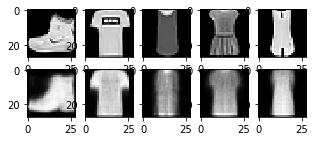

[Epoch 2]


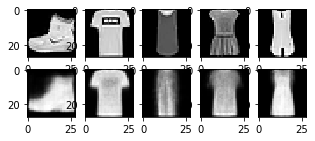

[Epoch 3]


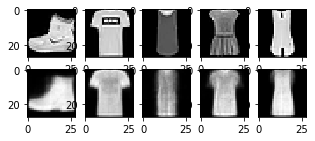

[Epoch 4]


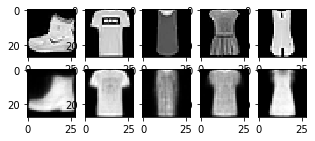

[Epoch 5]


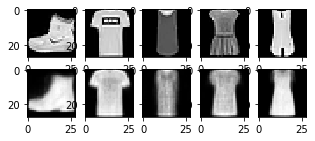

[Epoch 6]


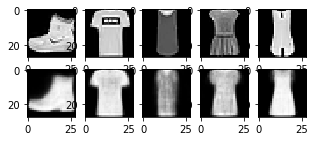

[Epoch 7]


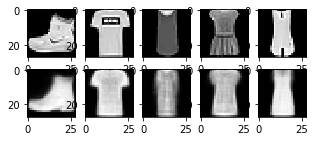

[Epoch 8]


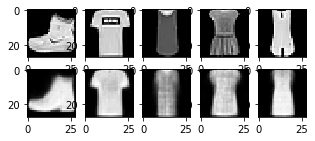

[Epoch 9]


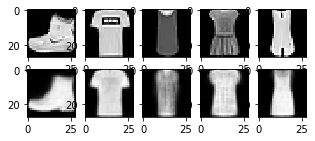

[Epoch 10]


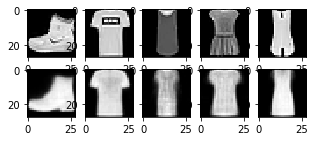

In [8]:
for epoch in range(1, EPOCHS+1):
    train(autoencoder, train_loader)
    test_x = view_data.to(device)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, 5, figsize=(5,2))
    print("[Epoch {}]".format(epoch))

    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28,28))
        a[0][i].imshow(img, cmap='gray')

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28,28))
        a[1][i].imshow(img, cmap='gray')
        
    plt.show()

### 잠재 변수를 3D 플롯으로 시각화

In [11]:
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255
test_x = view_data.to(device)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')

In [12]:
CLASS = {
    0: 'T-Shirt/Top',
    1: 'Trouser',
    2: 'Pullober',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

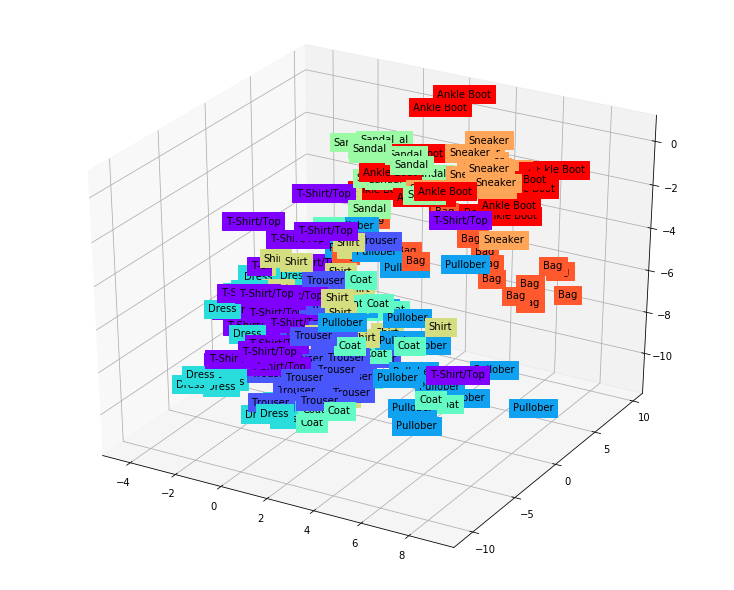

In [14]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x,y,z,s in zip(X,Y,Z,labels):
    name = CLASS[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

### 이미지 복원

In [15]:
def add_noise(img):
    noise = torch.rand(img.size())*0.2
    noisy_img = img + noise
    return noisy_img

In [16]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x)
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [18]:
for epoch in range(1, EPOCHS+1):
    loss = train(autoencoder, train_loader)
    print("[EPOCH {}] loss:{}".format(epoch, loss))

[EPOCH 1] loss:0.026438392228139106
[EPOCH 2] loss:0.02571104625776124
[EPOCH 3] loss:0.025469498454666596
[EPOCH 4] loss:0.025442417679247317
[EPOCH 5] loss:0.025303687455494012
[EPOCH 6] loss:0.025176135954190926
[EPOCH 7] loss:0.025240649220976494
[EPOCH 8] loss:0.025137307930555044
[EPOCH 9] loss:0.025047564325032075
[EPOCH 10] loss:0.025324797361040676


In [19]:
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [20]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(device)
_, recovered_x = autoencoder(noisy_x)

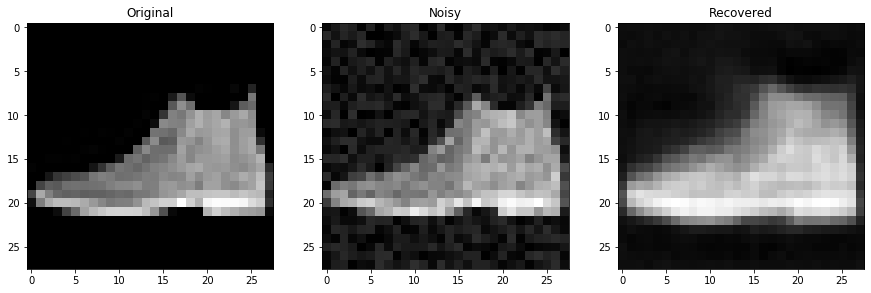

In [21]:
f, a = plt.subplots(1, 3, figsize=(15,15))
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')